In [95]:
!pip install "gymnasium[mujoco]"
!pip install mpi4py


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [96]:
import os
import subprocess
import torch
from matplotlib import pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd

In [97]:
env_file = 'model_downloader.py'
env_url = "https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/utils/model_downloader.py"

if not os.path.isfile(env_file):
    print(f"Downloading {env_file} ...")
    subprocess.run(
        ['wget', '-q', '-O', env_file, env_url],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    print(f"{env_file} downloaded.")
else:
    print(f"{env_file} already exists.")

from model_downloader import download_file, download_everything

trajectory = download_everything('TBP, ddpg, td3, sac, ppo, models, td3_models, sac_models, ppo_models, ddpg_models', folder_name=True)

from DDPG import DDPG
from DDPG import MLPActorCritic
from SAC import SAC
from utils.run_utils import setup_logger_kwargs
import TBP
from TBP import ThreeBodyEnv
from PPO import PPO
from TD3 import TD3
import torch

model_downloader.py already exists.
trajectory.csv already exists.
Trajectory head:
   0.87018  -0.059444  0  -0.010472  -0.17514  0.1
0  0.87018  -0.059540  0  -0.010536  -0.17494    0
1  0.87017  -0.059636  0  -0.010600  -0.17474    0
2  0.87017  -0.059732  0  -0.010664  -0.17454    0
3  0.87016  -0.059828  0  -0.010728  -0.17434    0
4  0.87015  -0.059924  0  -0.010793  -0.17414    0
Data shape: (9999, 6)
TBP.py already exists.
DDPG.py already exists.
Directory 'model_DDPG' already exists and is not empty.
model_DDPG/actor_cuda.pth already exists.
model_DDPG/q_cuda.pth already exists.
Directory 'model_DDPG' already exists and is not empty.
model_DDPG/actor_cuda.pth already exists.
model_DDPG/q_cuda.pth already exists.
PPO.py already exists.
Directory 'model_PPO' already exists and is not empty.
model_PPO/actor_cpu.pth already exists.
model_PPO/v_cpu.pth already exists.
SAC.py already exists.
Directory 'model_SAC' already exists and is not empty.
model_SAC/actor_cpu.pth already exist

In [98]:
import TBP
from TBP import ThreeBodyEnv
df = pd.read_csv('trajectory.csv')
# df to numpy array
data = df.to_numpy()
print(data.shape)
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)

(9999, 6)


[ 0.00935428 -0.00359586  0.0221152  -0.01098366]
idx 0.02607 state 0.02664874450396042
too much error 🥲😱
second player was in the game


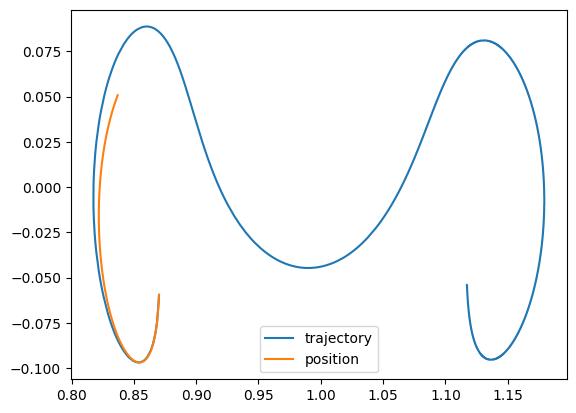

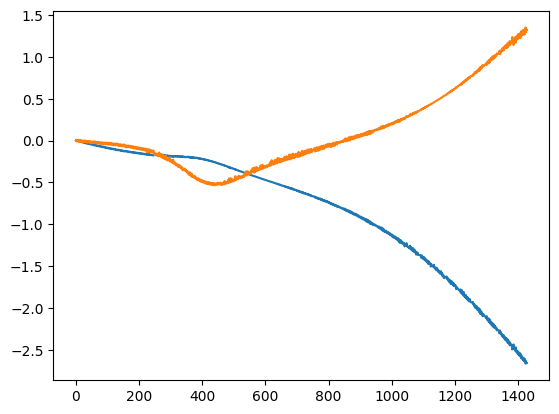

In [99]:
env = ThreeBodyEnv(trajectory_=trajectory,
    error_range=0.01, final_range=0.001)
env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(6000):
    action = -120 * env.state[2:] - 1 * env.state[:2]
    # print(i)
    # print(action)
    action_array.append(action)
    state, reward, done, _, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legned
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)


## DDPGG

Logging data to /Users/Ali/Documents/BAI/Master/master-thesis/Code/Python/Robust_eval/Standard_PID/actuator_disturbance/data/ddpg/ddpg_s0/progress.txt
Saving config:

{
    "ac_kwargs_":	{
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "act_dim":	2,
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	1024,
    "device_":	"cpu",
    "env_fn":	"make_env",
    "epochs_":	50,
    "exp_name":	"ddpg",
    "gamma_":	0.99,
    "logger_kwargs_":	{
        "exp_name":	"ddpg",
        "output_dir":	"/Users/Ali/Documents/BAI/Master/master-thesis/Code/Python/Robust_eval/Standard_PID/actuator_disturbance/data/ddpg/ddpg_s0"
    },
    "max_ep_len":	6000,
    "num_test_episodes":	10,
    "obs_dim":	[
        4
    ],
    "p":	"Parameter containing:\ntensor([-0.1749])",
    "pi_lr":	0.001,
    "polyak":	0.995,
    "q_lr":	0.001,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed_":	0,
    "self":	{
        "<DDPG.DDPG object at 0x160503290

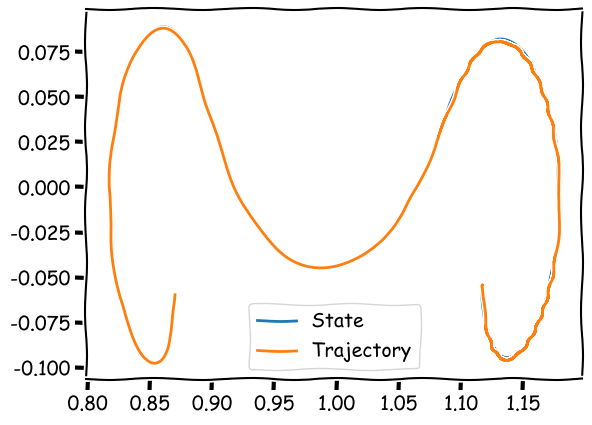

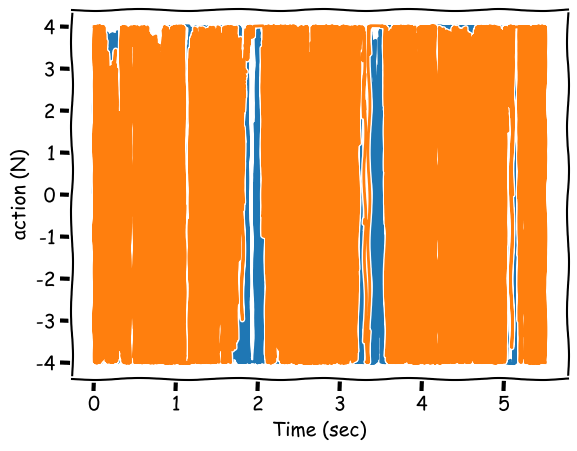

In [100]:
# Common hyperparameters and settings
hid = 32
l = 2
seed = 0
epochs = 50
exp_name = 'ddpg'
steps_per_epoch = 30000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper function to create the environment
def make_env(error_range=0.01, final_range=0.001):
    return ThreeBodyEnv(trajectory, error_range=error_range, final_range=final_range)

ac_kwargs = dict(hidden_sizes=[hid] * l)
logger_kwargs = setup_logger_kwargs(exp_name, seed)

ddpg = DDPG(
    env_fn=make_env,
    actor_critic=MLPActorCritic,
    ac_kwargs_=ac_kwargs,
    seed_=seed,
    steps_per_epoch=steps_per_epoch,
    epochs_=epochs,
    logger_kwargs_=logger_kwargs,
    device_=device,
    batch_size=1024,
    start_steps=5000,
    update_after=1000,
    update_every=2000
)

ddpg.load(from_device_to_load='cuda', filepath='model_DDPG/')
ddpg.test(fun_mode=True)
ddpg.env.second_player = False

## TD3

Logging data to /tmp/experiments/1763999764/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	1024,
    "env_fn":	"<function <lambda> at 0x160466a20>",
    "epochs":	100,
    "gamma":	0.99,
    "logger_kwargs":	null,
    "max_ep_len":	30000,
    "noise_clip":	0.5,
    "num_test_episodes":	10,
    "pi_lr":	0.001,
    "policy_delay":	2,
    "polyak":	0.995,
    "q_lr":	0.001,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed":	0,
    "self":	{
        "<TD3.TD3 object at 0x1604490d0>":	{
            "ac_kwargs":	{
                "hidden_sizes":	[
                    32,
                    32
                ]
            },
            "act_noise":	0.1,
            "actor_critic":	"MLPActorCritic",
            "batch_size":	1024,
            "env_fn":	"<function <lambda> at 0x160466a20>",
            "epochs":	100,
            "

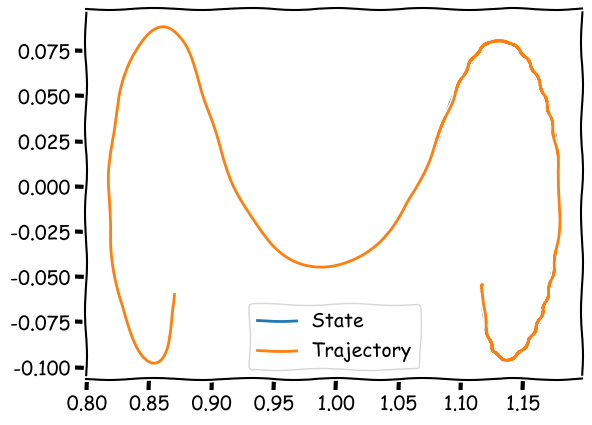

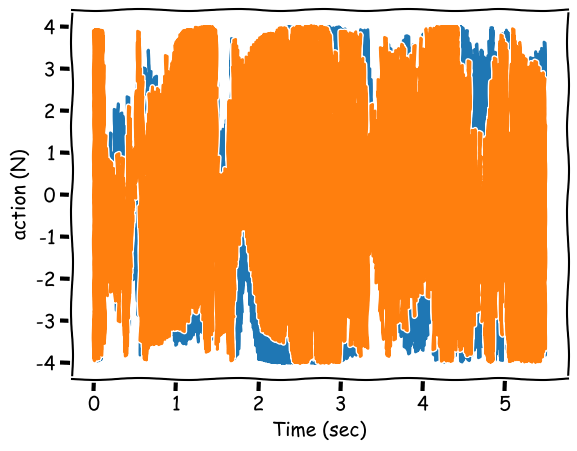

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(colorize(f"Device is {device}! 🥰😎", 'green', bold=True))
# Define variables directly
env = ThreeBodyEnv(trajectory)
hid = 32
l = 2
gamma = 0.99
seed = 0
epochs = 50
exp_name = 'td3'
steps_per_epoch_=30000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ac_kwargs = dict(hidden_sizes=[hid]*l)
states_array = []
# logger_kwargs = setup_logger_kwargs(exp_name, seed)
reward_array=[]

td3 = TD3(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), epochs=100, ac_kwargs=ac_kwargs, steps_per_epoch=steps_per_epoch_, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)

td3.load(filepath='model_TD3/')


# test td3 agent (not trained)
td3.test(fun_mode=True, deterministic=True, save_data=False)

# zs_td3.test(fun_mode=True)
td3.env.second_player = False

## SAC

Logging data to /tmp/experiments/1763999768/progress.txt
Saving config:

{
    "ac_kwargs_class":	{
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	1024,
    "device_class":	"cpu",
    "env_fn":	"<function <lambda> at 0x1604168e0>",
    "epochs":	100,
    "gamma":	0.99,
    "logger_kwargs":	null,
    "lr":	0.001,
    "max_ep_len":	30000,
    "num_test_episodes":	10,
    "num_updates":	10,
    "polyak":	0.995,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed":	0,
    "self":	{
        "<SAC.SAC object at 0x164c3dd90>":	{
            "ac_kwargs":	{
                "hidden_sizes":	[
                    64,
                    64
                ]
            },
            "actor_critic":	"MLPActorCritic",
            "alpha":	0.2,
            "batch_size":	1024,
            "device":	"cpu",
            "env_fn":	"<function <lambda> at 0x1604168e0>",
            "epochs":	100,
    

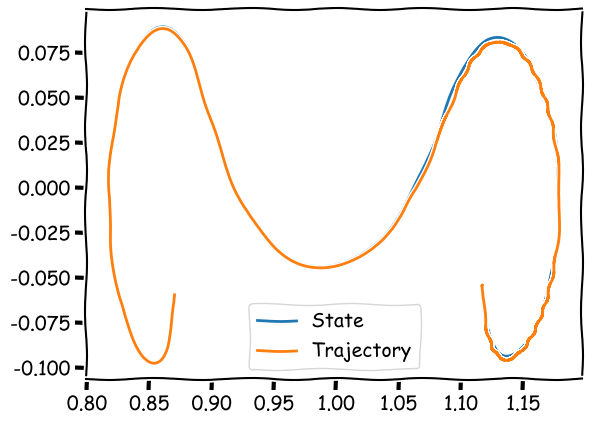

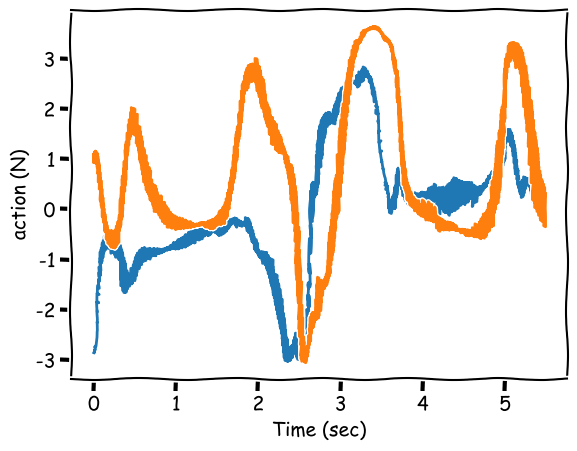

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(colorize(f"Device is {device}! 🥰😎", 'green', bold=True))
# Define variables directly
env = ThreeBodyEnv(trajectory)
hid = 64
l = 2
gamma = 0.99
seed = 0
epochs = 50
exp_name = 'sac'
steps_per_epoch_=30000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ac_kwargs = dict(hidden_sizes=[hid]*l)
states_array = []
# logger_kwargs = setup_logger_kwargs(exp_name, seed)
reward_array=[]

sac = SAC(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), epochs=100, device_class=device, ac_kwargs_class=ac_kwargs, steps_per_epoch=steps_per_epoch_, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)


sac.load(filepath='model_SAC/')


# test sac agent (not trained)
sac.test(fun_mode=True, deterministic=True, save_data=False)
sac.env.second_player = False

## PPO

Logging data to /Users/Ali/Documents/BAI/Master/master-thesis/Code/Python/Robust_eval/Standard_PID/actuator_disturbance/data/PPO_3BP/PPO_3BP_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "clip_ratio":	0.2,
    "env":	{
        "<ThreeBodyEnv instance>":	{
            "action_space":	{
                "Box(-4.0, 4.0, (2,), float32)":	{
                    "_np_random":	null,
                    "_shape":	[
                        2
                    ],
                    "bounded_above":	"[ True  True]",
                    "bounded_below":	"[ True  True]",
                    "dtype":	"float32",
                    "high":	"[4. 4.]",
                    "high_repr":	"4.0",
                    "low":	"[-4. -4.]",
                    "low_repr":	"-4.0"
                }
            },
            "dt":	0.001,
            "error_range":	0.01,
            "final_range":	0.001,
            "max_steps":	6

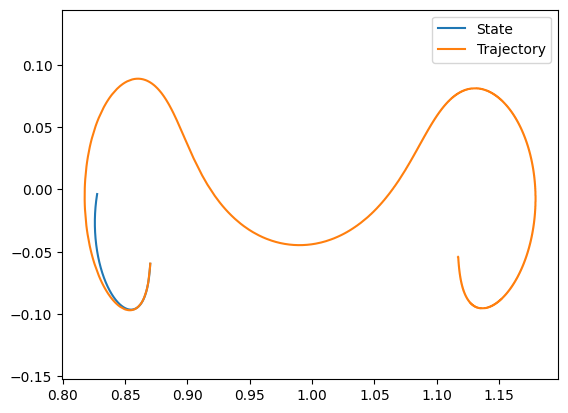

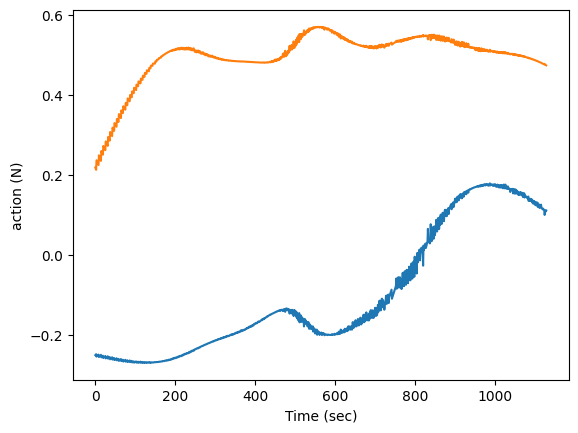

Model loaded successfully and device is cpu! 🥰😎
done 🥺
second player was in the game
(9999, 6)


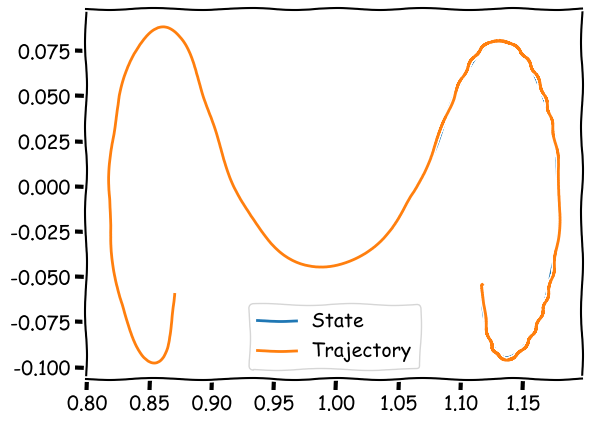

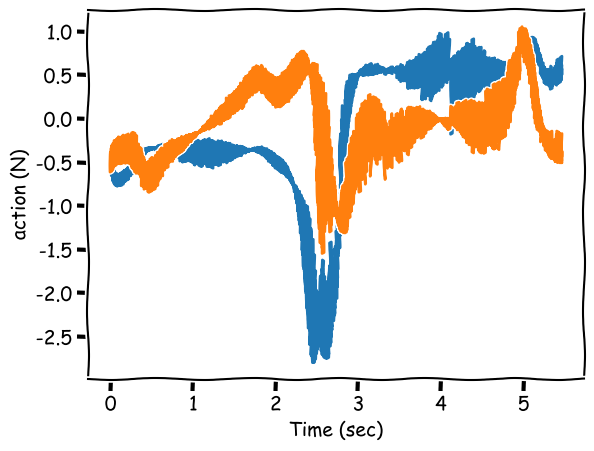

In [103]:
from PPO import PPO

# Define constants
HID = 32
L = 2
GAMMA = 0.99
SEED = 0
STEPS = 30000
EPOCHS = 100
EXP_NAME = 'PPO_3BP'
ac_kwargs = dict(hidden_sizes=[HID] * L)
# Use the constants directly


logger_kwargs = setup_logger_kwargs(EXP_NAME, SEED)

ppo = PPO(ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), ac_kwargs=ac_kwargs, gamma=GAMMA,
            seed=SEED, steps_per_epoch=STEPS, logger_kwargs=logger_kwargs)
# test PPO agent (not trained)
ppo.test(deterministic=True)

ppo.load(filepath='model_PPO/')
ppo.test(fun_mode=True)
ppo.env.second_player = False

In [104]:
class ActuatorDisturbanceWrapper(gym.Wrapper):
    """
    Gym environment wrapper that adds disturbance and extra noise to the actions taken by the agent.
    This wrapper susacrts the Gymnasium API where:
      - reset returns: (observation, info)
      - step returns: (observation, reward, terminated, truncated, info)
    """

    def __init__(self, env, disturbance_std=0.05, noise_std=0.02):
        super(ActuatorDisturbanceWrapper, self).__init__(env)
        self.disturbance_std = disturbance_std  # Standard deviation of actuator disturbance
        self.noise_std = noise_std  # Standard deviation of extra noise

    def reset(self, **kwargs):
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            obs, info = result
            return obs, info
        else:
            return result

    def step(self, action):
        # Apply actuator disturbance and extra noise to the action
        action_with_disturbance = self._apply_disturbance(action)
        action_with_noise = self._apply_noise(action_with_disturbance)

        # Execute the action in the environment with added disturbance and noise
        obs, reward, terminated, truncated, info = self.env.step(action_with_noise)
        return obs, reward, terminated, truncated, info

    def _apply_disturbance(self, action):
        """
        Applies Gaussian noise to the action to simulate actuator disturbance.
        """
        action = np.array(action)
        disturbance = np.random.normal(0, self.disturbance_std, size=action.shape)
        return np.clip(action + disturbance, self.env.action_space.low, self.env.action_space.high)

    def _apply_noise(self, action):
        """
        Applies additional random noise to the action.
        """
        noise = np.random.normal(0, self.noise_std, size=action.shape) * action
        return action + noise


def make_env_actuator_disturbance_with_noise(error_range=0.01, final_range=0.001, disturbance_std=0.05, noise_std=0.02):
    """
    Creates the ThreeBodyEnv wrapped with both actuator disturbance and extra noise.
    """
    env = ThreeBodyEnv(trajectory, error_range=error_range, final_range=final_range)
    return ActuatorDisturbanceWrapper(env, disturbance_std=disturbance_std, noise_std=noise_std)


In [105]:
def run_episode(agent, env_fn, max_steps=10000, deterministic=True, agent_no="ddpg"):
    """
    Run one episode using the given agent and environment function.
    Adapted for Gymnasium (reset returns (obs, info) and step returns five outputs).

    Args:
        agent: The RL agent with an action selection method (or None for PID/benchmark)
        env_fn: Function that creates the environment
        max_steps: Maximum steps per episode
        deterministic: Whether to use deterministic action selection
        agent_no: Agent type identifier

    Returns:
        total_reward: Sum of rewards collected in the episode.
        avg_error_per_step: Average position error per step
        num_of_fails: Number of fails (terminated with negative reward)
        avg_action_magnitude_per_step: Average magnitude of actions per step
    """
    env = env_fn()

    obs, _ = env.reset()  # Gymnasium reset returns (obs, info)
    total_reward = 0.0
    total_error = 0.0
    num_of_fails = 0
    total_actions = 0.0
    steps = 0
    done = False
    env.second_player = False

    while not done and steps < max_steps:
        # Select action based on the specified method
        if agent_no == "ddpg":
            action = agent.get_action(obs, 0)
        elif agent_no == "td3":
            action = agent.ac.act(torch.as_tensor(obs, dtype=torch.float32))
        elif agent_no == "sac":
            action = agent.ac.act(torch.as_tensor(obs, dtype=torch.float32, device=device), deterministic=True)
        elif agent_no == "ppo":
            action, _, _ = agent.ac.step(torch.as_tensor(obs, dtype=torch.float32), deterministic=True)
        elif agent_no == "pid":
            # PID controller: action = -Kp * position_error - Kd * velocity_error
            action = -12000 * obs[2:] - 1000 * obs[:2]
            # clip action to action space
            action = np.clip(action, -4, 4)
        elif agent_no == "benchmark":
            # Benchmark controller (zero action)
            action = np.zeros(2)
        else:
            raise ValueError(f"Unknown agent type: {agent_no}")
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated  # Determine if the episode is done
        total_reward += reward
        steps += 1

        # Calculate additional metrics
        total_error += np.dot(obs[0:2], obs[0:2])**0.5
        total_actions += np.dot(action, action)**0.5
        if done and reward < 0:
            num_of_fails += 1

    env.close()
    return total_reward, total_error/steps, num_of_fails, total_actions/steps


def evaluate_agent(agent, env_fn, num_episodes=20, max_steps=10000, deterministic=True, agent_name=""):
    """
    Evaluate the agent over multiple episodes and collect cumulative rewards.

    Args:
        agent: The RL agent to evaluate (or None for PID/benchmark)
        env_fn: Function that creates the environment
        num_episodes: Number of episodes to run
        max_steps: Maximum steps per episode
        deterministic: Whether to use deterministic action selection
        agent_name: Name of the agent for logging purposes

    Returns:
        returns: List of cumulative rewards from each episode.
        errors: List of average errors per step from each episode.
        fails: List of number of fails per episode.
        actions: List of average action magnitudes per step from each episode.
    """
    returns = []
    errors = []
    fails = []
    actions = []
    for i in range(num_episodes):
        ret, error, fail, action = run_episode(agent, env_fn, max_steps, deterministic=deterministic, agent_no=agent_name)
        returns.append(ret)
        errors.append(error)
        fails.append(fail)
        actions.append(action)
        print(f"{agent_name}: Episode {i+1}/{num_episodes}, Return: {ret:.2f}, Error: {error:.4f}, Fails: {fail}, Action: {action:.4f}")
    return returns, errors, fails, actions


In [106]:
# Set disturbance parameters
disturbance_std = 0.5
noise_std = 0.1

# Number of episodes for evaluation
num_episodes = 10

# Update all agents' environment functions to use both actuator disturbance and extra noise
ppo.env_fn = lambda: make_env_actuator_disturbance_with_noise(disturbance_std=disturbance_std, noise_std=noise_std)
sac.env_fn = lambda: make_env_actuator_disturbance_with_noise(disturbance_std=disturbance_std, noise_std=noise_std)
td3.env_fn = lambda: make_env_actuator_disturbance_with_noise(disturbance_std=disturbance_std, noise_std=noise_std)
ddpg.env_fn = lambda: make_env_actuator_disturbance_with_noise(disturbance_std=disturbance_std, noise_std=noise_std)

# Evaluate RL agents
returns_ddpg, errors_ddpg, fails_ddpg, actions_ddpg = evaluate_agent(ddpg, ddpg.env_fn, num_episodes=num_episodes, agent_name="ddpg")
returns_td3, errors_td3, fails_td3, actions_td3 = evaluate_agent(td3, td3.env_fn, num_episodes=num_episodes, agent_name="td3")
returns_sac, errors_sac, fails_sac, actions_sac = evaluate_agent(sac, sac.env_fn, num_episodes=num_episodes, agent_name="sac")
returns_ppo, errors_ppo, fails_ppo, actions_ppo = evaluate_agent(ppo, ppo.env_fn, num_episodes=num_episodes, agent_name="ppo")



# Evaluate Benchmark (zero action)
# benchmark_env_fn = lambda: make_env_actuator_disturbance_with_noise(disturbance_std=disturbance_std, noise_std=noise_std)
# returns_benchmark, errors_benchmark, fails_benchmark, actions_benchmark = evaluate_agent(None, benchmark_env_fn, num_episodes=num_episodes, agent_name="benchmark")


done 🥺
second player was in the game
ddpg: Episode 1/10, Return: -376.61, Error: 0.3722, Fails: 0, Action: 4.8849
done 🥺
second player was in the game
ddpg: Episode 2/10, Return: -384.72, Error: 0.3713, Fails: 0, Action: 4.8867
done 🥺
second player was in the game
ddpg: Episode 3/10, Return: -376.31, Error: 0.3719, Fails: 0, Action: 4.8966
done 🥺
second player was in the game
ddpg: Episode 4/10, Return: -389.34, Error: 0.3767, Fails: 0, Action: 4.8795
done 🥺
second player was in the game
ddpg: Episode 5/10, Return: -384.43, Error: 0.3721, Fails: 0, Action: 4.8831
done 🥺
second player was in the game
ddpg: Episode 6/10, Return: -381.94, Error: 0.3733, Fails: 0, Action: 4.8818
done 🥺
second player was in the game
ddpg: Episode 7/10, Return: -384.04, Error: 0.3717, Fails: 0, Action: 4.8999
done 🥺
second player was in the game
ddpg: Episode 8/10, Return: -385.43, Error: 0.3747, Fails: 0, Action: 4.8650
done 🥺
second player was in the game
ddpg: Episode 9/10, Return: -386.97, Error: 0.3718,

In [ ]:
# Evaluate PID controller
pid_env_fn = lambda: make_env_actuator_disturbance_with_noise(disturbance_std=disturbance_std, noise_std=noise_std)
returns_pid, errors_pid, fails_pid, actions_pid = evaluate_agent(None, pid_env_fn, num_episodes=num_episodes, agent_name="pid")

[ 0.00911045  0.00417868  0.04545612 -0.00659201]
idx 0.04101 state 0.04701250268643549
too much error 🥲😱
second player was in the game
pid: Episode 1/10, Return: -2992.47, Error: 1.9406, Fails: 1, Action: 5.6536
[ 0.00899465 -0.00438449  0.02495744 -0.01355611]
idx 0.02688 state 0.030112617009308566
too much error 🥲😱
second player was in the game
pid: Episode 2/10, Return: -1876.71, Error: 2.1326, Fails: 1, Action: 5.6530
[ 0.00883947 -0.00469111  0.02409429 -0.01148702]
idx 0.02744 state 0.028506653319324345
too much error 🥲😱
second player was in the game
pid: Episode 3/10, Return: -1872.19, Error: 2.1661, Fails: 1, Action: 5.6531
[ 0.00958516 -0.00295063  0.02679186 -0.01488911]
idx 0.02519 state 0.03225012755744919
too much error 🥲😱
second player was in the game
pid: Episode 4/10, Return: -1908.72, Error: 2.1727, Fails: 1, Action: 5.6524
[ 0.00934046 -0.00365144  0.02631997 -0.01317481]
idx 0.02625 state 0.031094913586259976
too much error 🥲😱
second player was in the game
pid: Epis

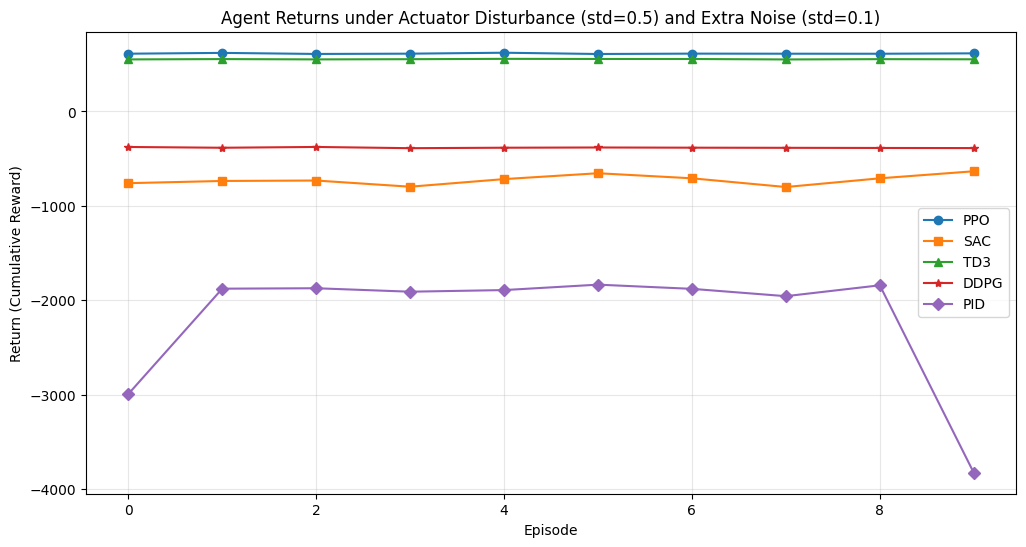

In [117]:
# labels
returns_ppo_label = "PPO"
returns_sac_label = "SAC"
returns_td3_label = "TD3"
returns_ddpg_label = "DDPG"
returns_pid_label = "PID"
returns_benchmark_label = "Benchmark"

# Plot the returns for visual comparison
plt.figure(figsize=(12, 6))
plt.plot(returns_ppo, marker='o', label=returns_ppo_label)
plt.plot(returns_sac, marker='s', label=returns_sac_label)
plt.plot(returns_td3, marker='^', label=returns_td3_label)
plt.plot(returns_ddpg, marker='*', label=returns_ddpg_label)
plt.plot(returns_pid, marker='D', label=returns_pid_label)
# plt.plot(returns_benchmark, marker='x', label=returns_benchmark_label)
plt.xlabel('Episode')
plt.ylabel('Return (Cumulative Reward)')
plt.title(f'Agent Returns under Actuator Disturbance (std={disturbance_std}) and Extra Noise (std={noise_std})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/var/folders/cf/x6zpxdwn2dg40q0c0r418f7c0000gp/T/ipykernel_1571/4091724694.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True)


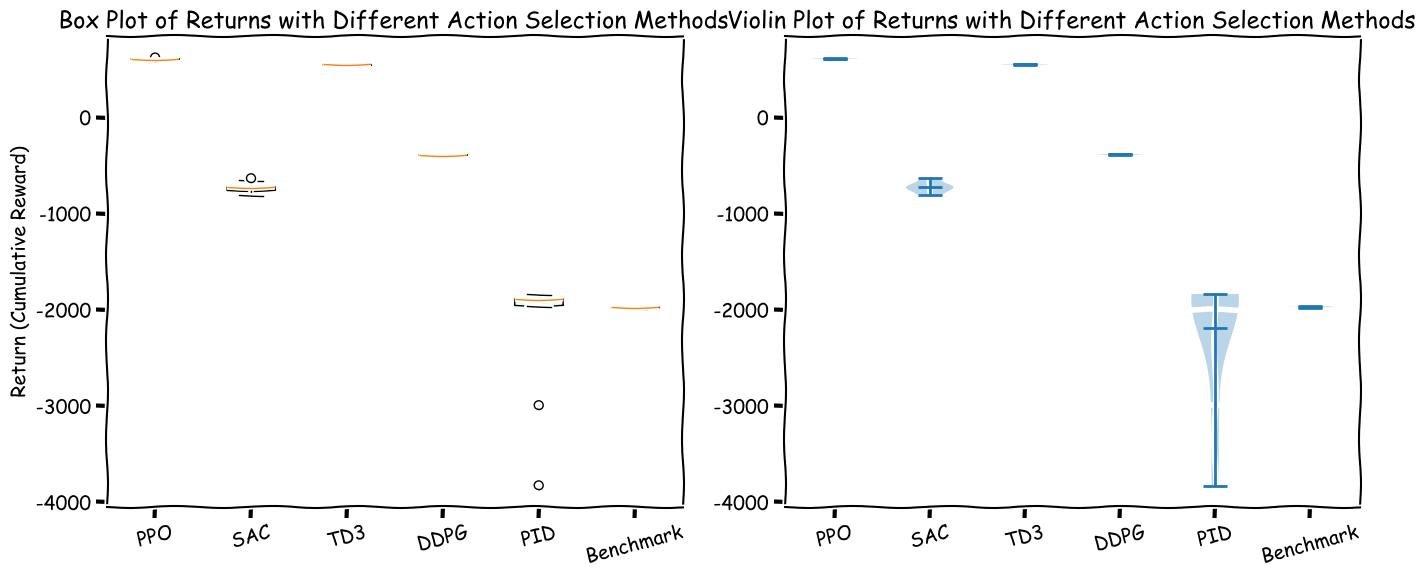

In [118]:
# Create box and violin plots for all algorithms
data = [returns_ppo, returns_sac, returns_td3, returns_ddpg, returns_pid, returns_benchmark]
labels = [returns_ppo_label, returns_sac_label, returns_td3_label, returns_ddpg_label, returns_pid_label, returns_benchmark_label]

with plt.xkcd():
    # Create a figure with two subplots side-by-side
    plt.figure(figsize=(14, 6))

    # Box Plot
    plt.subplot(1, 2, 1)
    box = plt.boxplot(data, labels=labels, patch_artist=True)

    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightpink', 'lightsalmon', 'lightcyan', 'lightgray']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.title('Box Plot of Returns with Different Action Selection Methods')
    plt.ylabel('Return (Cumulative Reward)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=15)

    # Violin Plot
    plt.subplot(1, 2, 2)
    violin = plt.violinplot(data, showmeans=True)
    plt.xticks([1, 2, 3, 4, 5, 6], labels, rotation=15)
    plt.title('Violin Plot of Returns with Different Action Selection Methods')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [110]:
# Create a DataFrame with all results
df = pd.DataFrame({
    returns_ppo_label: returns_ppo,
    returns_sac_label: returns_sac,
    returns_td3_label: returns_td3,
    returns_ddpg_label: returns_ddpg,
    returns_pid_label: returns_pid,
    returns_benchmark_label: returns_benchmark
})

# Display the head of the dataframe
df.head()


,PPO,SAC,TD3,DDPG,PID,Benchmark
0,610.904121,-759.799550,550.478556,-376.607427,726.009575,-1969.700079
1,619.514853,-736.335993,553.858501,-384.724818,736.310913,-1967.132517
2,608.256348,-731.760223,550.635285,-376.308499,714.744887,-1967.362441
3,611.269599,-797.215287,552.776602,-389.336117,717.394236,-1972.389290
4,621.302595,-716.701389,556.412605,-384.429579,702.964839,-1978.757531


In [111]:
# Calculate summary statistics
summary = df.describe()
print("Summary Statistics:")
print(summary)


Summary Statistics:
              PPO         SAC         TD3        DDPG         PID    Benchmark
count   10.000000   10.000000   10.000000   10.000000   10.000000    10.000000
mean   612.668928 -724.725799  552.913575 -383.804204  724.221862 -1968.267695
std      4.510008   53.960135    2.199359    4.420548   12.192563     5.428308
min    607.793449 -800.488844  550.060127 -389.336117  702.964839 -1978.757531
25%    610.528369 -753.933660  550.873013 -386.582103  715.407225 -1971.716987
50%    611.086860 -724.230806  552.993335 -384.577198  725.048316 -1967.247479
75%    613.936238 -708.259259  554.625726 -382.463467  733.775369 -1966.176325
max    621.302595 -633.744629  556.412605 -376.308499  740.343316 -1960.167943


In [112]:
# Save results to CSV with timestamp to avoid overwriting
from datetime import datetime
filename = 'evaluation_returns.csv'
df.to_csv(filename, index=False)
print(f"Results saved to {filename}")

# Also save a parameter summary for reference

Results saved to evaluation_returns.csv


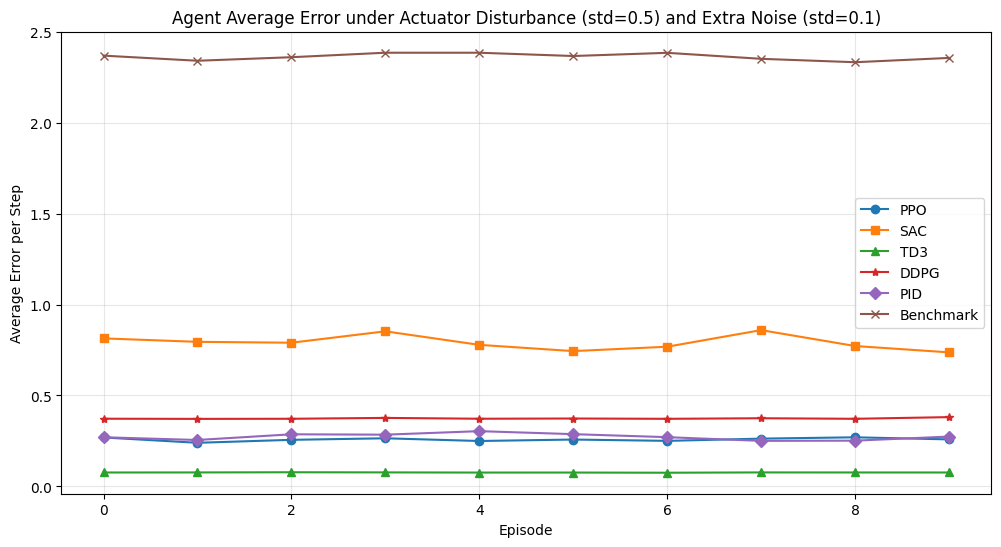

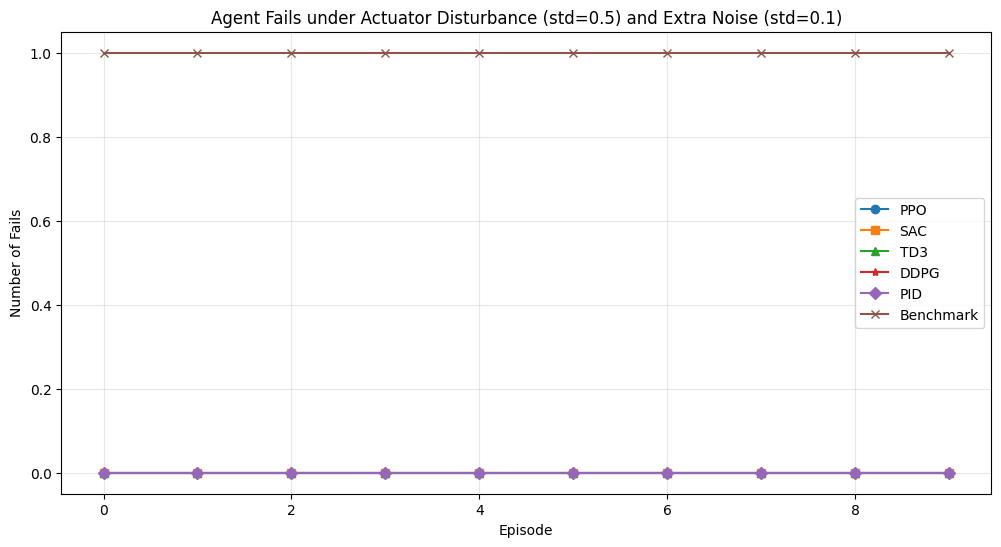

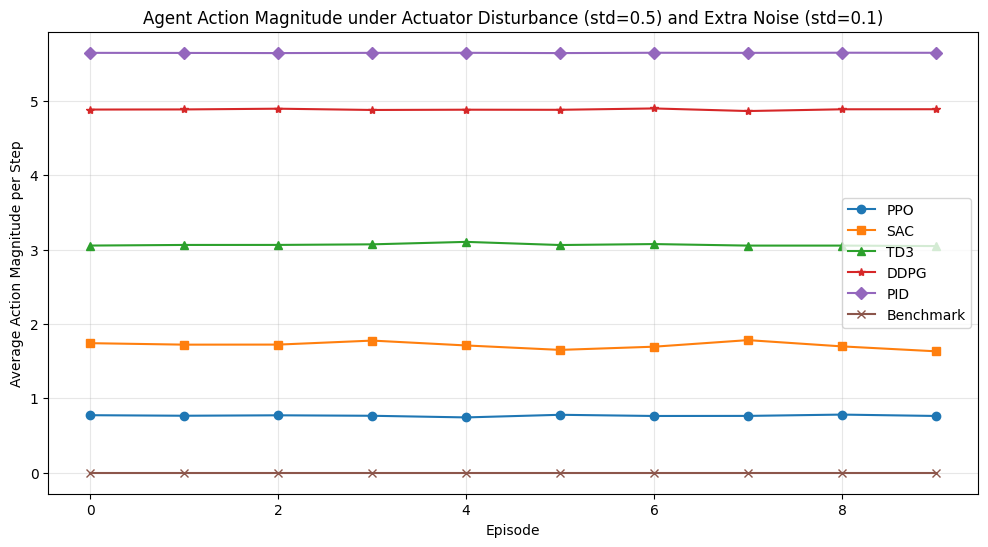


Average Metrics:
PPO - Return: 612.67, Error: 0.2578, Fails: 0.00, Action: 0.7675
SAC - Return: -724.73, Error: 0.7911, Fails: 0.00, Action: 1.7141
TD3 - Return: 552.91, Error: 0.0765, Fails: 0.00, Action: 3.0658
DDPG - Return: -383.80, Error: 0.3737, Fails: 0.00, Action: 4.8855
PID - Return: 724.22, Error: 0.2734, Fails: 0.00, Action: 5.6474
Benchmark - Return: -1968.27, Error: 2.3631, Fails: 1.00, Action: 0.0000

Normalized Metrics:
PPO - Return: 0.61, Error: 257.85, Fails: 0.00, Action: 0.77
SAC - Return: -0.72, Error: 791.08, Fails: 0.00, Action: 1.71
TD3 - Return: 0.55, Error: 76.55, Fails: 0.00, Action: 3.07
DDPG - Return: -0.38, Error: 373.66, Fails: 0.00, Action: 4.89
PID - Return: 0.72, Error: 273.42, Fails: 0.00, Action: 5.65
Benchmark - Return: -1.97, Error: 2363.06, Fails: 0.10, Action: 0.00

LaTeX Table Format:
PPO & $0.61$ & $257.85$ & $0.77$ & $0.00$ \\
SAC & $-0.72$ & $791.08$ & $1.71$ & $0.00$ \\
TD3 & $0.55$ & $76.55$ & $3.07$ & $0.00$ \\
DDPG & $-0.38$ & $373.66$ & 

In [113]:
# Plot additional metrics
# Average error per step
plt.figure(figsize=(12, 6))
plt.plot(errors_ppo, marker='o', label=returns_ppo_label)
plt.plot(errors_sac, marker='s', label=returns_sac_label)
plt.plot(errors_td3, marker='^', label=returns_td3_label)
plt.plot(errors_ddpg, marker='*', label=returns_ddpg_label)
plt.plot(errors_pid, marker='D', label=returns_pid_label)
plt.plot(errors_benchmark, marker='x', label=returns_benchmark_label)
plt.xlabel('Episode')
plt.ylabel('Average Error per Step')
plt.title(f'Agent Average Error under Actuator Disturbance (std={disturbance_std}) and Extra Noise (std={noise_std})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Number of fails
plt.figure(figsize=(12, 6))
plt.plot(fails_ppo, marker='o', label=returns_ppo_label)
plt.plot(fails_sac, marker='s', label=returns_sac_label)
plt.plot(fails_td3, marker='^', label=returns_td3_label)
plt.plot(fails_ddpg, marker='*', label=returns_ddpg_label)
plt.plot(fails_pid, marker='D', label=returns_pid_label)
plt.plot(fails_benchmark, marker='x', label=returns_benchmark_label)
plt.xlabel('Episode')
plt.ylabel('Number of Fails')
plt.title(f'Agent Fails under Actuator Disturbance (std={disturbance_std}) and Extra Noise (std={noise_std})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Average action magnitude
plt.figure(figsize=(12, 6))
plt.plot(actions_ppo, marker='o', label=returns_ppo_label)
plt.plot(actions_sac, marker='s', label=returns_sac_label)
plt.plot(actions_td3, marker='^', label=returns_td3_label)
plt.plot(actions_ddpg, marker='*', label=returns_ddpg_label)
plt.plot(actions_pid, marker='D', label=returns_pid_label)
plt.plot(actions_benchmark, marker='x', label=returns_benchmark_label)
plt.xlabel('Episode')
plt.ylabel('Average Action Magnitude per Step')
plt.title(f'Agent Action Magnitude under Actuator Disturbance (std={disturbance_std}) and Extra Noise (std={noise_std})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate average metrics
avg_return_ppo = np.mean(returns_ppo)
avg_return_sac = np.mean(returns_sac)
avg_return_td3 = np.mean(returns_td3)
avg_return_ddpg = np.mean(returns_ddpg)
avg_return_pid = np.mean(returns_pid)
avg_return_benchmark = np.mean(returns_benchmark)

avg_error_ppo = np.mean(errors_ppo)
avg_error_sac = np.mean(errors_sac)
avg_error_td3 = np.mean(errors_td3)
avg_error_ddpg = np.mean(errors_ddpg)
avg_error_pid = np.mean(errors_pid)
avg_error_benchmark = np.mean(errors_benchmark)

avg_fails_ppo = np.mean(fails_ppo)
avg_fails_sac = np.mean(fails_sac)
avg_fails_td3 = np.mean(fails_td3)
avg_fails_ddpg = np.mean(fails_ddpg)
avg_fails_pid = np.mean(fails_pid)
avg_fails_benchmark = np.mean(fails_benchmark)

avg_actions_ppo = np.mean(actions_ppo)
avg_actions_sac = np.mean(actions_sac)
avg_actions_td3 = np.mean(actions_td3)
avg_actions_ddpg = np.mean(actions_ddpg)
avg_actions_pid = np.mean(actions_pid)
avg_actions_benchmark = np.mean(actions_benchmark)

# Print average metrics
print("\nAverage Metrics:")
print(f"PPO - Return: {avg_return_ppo:.2f}, Error: {avg_error_ppo:.4f}, Fails: {avg_fails_ppo:.2f}, Action: {avg_actions_ppo:.4f}")
print(f"SAC - Return: {avg_return_sac:.2f}, Error: {avg_error_sac:.4f}, Fails: {avg_fails_sac:.2f}, Action: {avg_actions_sac:.4f}")
print(f"TD3 - Return: {avg_return_td3:.2f}, Error: {avg_error_td3:.4f}, Fails: {avg_fails_td3:.2f}, Action: {avg_actions_td3:.4f}")
print(f"DDPG - Return: {avg_return_ddpg:.2f}, Error: {avg_error_ddpg:.4f}, Fails: {avg_fails_ddpg:.2f}, Action: {avg_actions_ddpg:.4f}")
print(f"PID - Return: {avg_return_pid:.2f}, Error: {avg_error_pid:.4f}, Fails: {avg_fails_pid:.2f}, Action: {avg_actions_pid:.4f}")
print(f"Benchmark - Return: {avg_return_benchmark:.2f}, Error: {avg_error_benchmark:.4f}, Fails: {avg_fails_benchmark:.2f}, Action: {avg_actions_benchmark:.4f}")

# Normalized metrics for easier comparison
print("\nNormalized Metrics:")
print(f"PPO - Return: {avg_return_ppo/1000:.2f}, Error: {avg_error_ppo*1000:.2f}, Fails: {avg_fails_ppo/num_episodes:.2f}, Action: {avg_actions_ppo:.2f}")
print(f"SAC - Return: {avg_return_sac/1000:.2f}, Error: {avg_error_sac*1000:.2f}, Fails: {avg_fails_sac/num_episodes:.2f}, Action: {avg_actions_sac:.2f}")
print(f"TD3 - Return: {avg_return_td3/1000:.2f}, Error: {avg_error_td3*1000:.2f}, Fails: {avg_fails_td3/num_episodes:.2f}, Action: {avg_actions_td3:.2f}")
print(f"DDPG - Return: {avg_return_ddpg/1000:.2f}, Error: {avg_error_ddpg*1000:.2f}, Fails: {avg_fails_ddpg/num_episodes:.2f}, Action: {avg_actions_ddpg:.2f}")
print(f"PID - Return: {avg_return_pid/1000:.2f}, Error: {avg_error_pid*1000:.2f}, Fails: {avg_fails_pid/num_episodes:.2f}, Action: {avg_actions_pid:.2f}")
print(f"Benchmark - Return: {avg_return_benchmark/1000:.2f}, Error: {avg_error_benchmark*1000:.2f}, Fails: {avg_fails_benchmark/num_episodes:.2f}, Action: {avg_actions_benchmark:.2f}")

# LaTeX table format for easy copy-paste
print("\nLaTeX Table Format:")
print(f"PPO & ${avg_return_ppo/1000:.2f}$ & ${avg_error_ppo*1000:.2f}$ & ${avg_actions_ppo:.2f}$ & ${avg_fails_ppo:.2f}$ \\\\")
print(f"SAC & ${avg_return_sac/1000:.2f}$ & ${avg_error_sac*1000:.2f}$ & ${avg_actions_sac:.2f}$ & ${avg_fails_sac:.2f}$ \\\\")
print(f"TD3 & ${avg_return_td3/1000:.2f}$ & ${avg_error_td3*1000:.2f}$ & ${avg_actions_td3:.2f}$ & ${avg_fails_td3:.2f}$ \\\\")
print(f"DDPG & ${avg_return_ddpg/1000:.2f}$ & ${avg_error_ddpg*1000:.2f}$ & ${avg_actions_ddpg:.2f}$ & ${avg_fails_ddpg:.2f}$ \\\\")
print(f"PID & ${avg_return_pid/1000:.2f}$ & ${avg_error_pid*1000:.2f}$ & ${avg_actions_pid:.2f}$ & ${avg_fails_pid:.2f}$ \\\\")
print(f"Benchmark & ${avg_return_benchmark/1000:.2f}$ & ${avg_error_benchmark*1000:.2f}$ & ${avg_actions_benchmark:.2f}$ & ${avg_fails_benchmark:.2f}$ \\\\")

# Create a DataFrame with all metrics
metrics_df = pd.DataFrame({
    'Algorithm': [returns_ppo_label, returns_sac_label, returns_td3_label, returns_ddpg_label, returns_pid_label, returns_benchmark_label],
    'Avg Return': [avg_return_ppo, avg_return_sac, avg_return_td3, avg_return_ddpg, avg_return_pid, avg_return_benchmark],
    'Avg Error': [avg_error_ppo, avg_error_sac, avg_error_td3, avg_error_ddpg, avg_error_pid, avg_error_benchmark],
    'Avg Fails': [avg_fails_ppo, avg_fails_sac, avg_fails_td3, avg_fails_ddpg, avg_fails_pid, avg_fails_benchmark],
    'Avg Action': [avg_actions_ppo, avg_actions_sac, avg_actions_td3, avg_actions_ddpg, avg_actions_pid, avg_actions_benchmark]
})

# Save the metrics DataFrame to CSV
metrics_filename = 'actuator_disturbance_metrics.csv'
metrics_df.to_csv(metrics_filename, index=False)
print(f"Metrics saved to {metrics_filename}")

# Also save the raw episode data
raw_data_df = pd.DataFrame({
    f"{returns_ppo_label}_Return": returns_ppo,
    f"{returns_ppo_label}_Error": errors_ppo,
    f"{returns_ppo_label}_Fails": fails_ppo,
    f"{returns_ppo_label}_Action": actions_ppo,
    f"{returns_sac_label}_Return": returns_sac,
    f"{returns_sac_label}_Error": errors_sac,
    f"{returns_sac_label}_Fails": fails_sac,
    f"{returns_sac_label}_Action": actions_sac,
    f"{returns_td3_label}_Return": returns_td3,
    f"{returns_td3_label}_Error": errors_td3,
    f"{returns_td3_label}_Fails": fails_td3,
    f"{returns_td3_label}_Action": actions_td3,
    f"{returns_ddpg_label}_Return": returns_ddpg,
    f"{returns_ddpg_label}_Error": errors_ddpg,
    f"{returns_ddpg_label}_Fails": fails_ddpg,
    f"{returns_ddpg_label}_Action": actions_ddpg,
    f"{returns_pid_label}_Return": returns_pid,
    f"{returns_pid_label}_Error": errors_pid,
    f"{returns_pid_label}_Fails": fails_pid,
    f"{returns_pid_label}_Action": actions_pid,
    f"{returns_benchmark_label}_Return": returns_benchmark,
    f"{returns_benchmark_label}_Error": errors_benchmark,
    f"{returns_benchmark_label}_Fails": fails_benchmark,
    f"{returns_benchmark_label}_Action": actions_benchmark
})

raw_data_filename = 'actuator_disturbance_raw_data.csv'
raw_data_df.to_csv(raw_data_filename, index=False)
print(f"Raw data saved to {raw_data_filename}")


In [114]:
# LaTeX table format for easy copy-paste
print("\nLaTeX Table Format:")
print(f"PPO & ${avg_return_ppo/1000:.2f}$ & ${avg_error_ppo*1000:.2f}$ & ${avg_actions_ppo:.2f}$ & ${avg_fails_ppo:.2f}$ \\\\")
print(f"SAC & ${avg_return_sac/1000:.2f}$ & ${avg_error_sac*1000:.2f}$ & ${avg_actions_sac:.2f}$ & ${avg_fails_sac:.2f}$ \\\\")
print(f"TD3 & ${avg_return_td3/1000:.2f}$ & ${avg_error_td3*1000:.2f}$ & ${avg_actions_td3:.2f}$ & ${avg_fails_td3:.2f}$ \\\\")
print(f"DDPG & ${avg_return_ddpg/1000:.2f}$ & ${avg_error_ddpg*1000:.2f}$ & ${avg_actions_ddpg:.2f}$ & ${avg_fails_ddpg:.2f}$ \\\\")





LaTeX Table Format:
PPO & $0.61$ & $257.85$ & $0.77$ & $0.00$ \\
SAC & $-0.72$ & $791.08$ & $1.71$ & $0.00$ \\
TD3 & $0.55$ & $76.55$ & $3.07$ & $0.00$ \\
DDPG & $-0.38$ & $373.66$ & $4.89$ & $0.00$ \\


In [115]:
print("\nLaTeX Table Format:")
print(r"\begin{tabular}{lcccccc}")
print(r"\hline")
print(r"Metric & DDPG & PPO & SAC & TD3 & PID & Benchmark \\")
print(r"\hline")
print(f"Return & ${avg_return_ddpg/1000:.2f}$ & ${avg_return_ppo/1000:.2f}$ & ${avg_return_sac/1000:.2f}$ & ${avg_return_td3/1000:.2f}$ & ${avg_return_pid/1000:.2f}$ & ${avg_return_benchmark/1000:.2f}$ \\\\")
print(f"Error  & ${avg_error_ddpg*1000:.2f}$ & ${avg_error_ppo*1000:.2f}$ & ${avg_error_sac*1000:.2f}$ & ${avg_error_td3*1000:.2f}$ & ${avg_error_pid*1000:.2f}$ & ${avg_error_benchmark*1000:.2f}$ \\\\")
print(f"Effort & ${avg_actions_ddpg:.2f}$ & ${avg_actions_ppo:.2f}$ & ${avg_actions_sac:.2f}$ & ${avg_actions_td3:.2f}$ & ${avg_actions_pid:.2f}$ & ${avg_actions_benchmark:.2f}$ \\\\")
print(f"Fail   & ${avg_fails_ddpg:.2f}$ & ${avg_fails_ppo:.2f}$ & ${avg_fails_sac:.2f}$ & ${avg_fails_td3:.2f}$ & ${avg_fails_pid:.2f}$ & ${avg_fails_benchmark:.2f}$ \\\\")
print(r"\hline")
print(r"\end{tabular}")



LaTeX Table Format:
\begin{tabular}{lcccccc}
\hline
Metric & DDPG & PPO & SAC & TD3 & PID & Benchmark \\
\hline
Return & $-0.38$ & $0.61$ & $-0.72$ & $0.55$ & $0.72$ & $-1.97$ \\
Error  & $373.66$ & $257.85$ & $791.08$ & $76.55$ & $273.42$ & $2363.06$ \\
Effort & $4.89$ & $0.77$ & $1.71$ & $3.07$ & $5.65$ & $0.00$ \\
Fail   & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $0.00$ & $1.00$ \\
\hline
\end{tabular}
